In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns

### Carico i file csv

In [2]:
train_path = ("train.csv")
test_path = ("test.csv")
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [3]:
train_data

,Unnamed: 0,No-show,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,13211,Yes,2.247937e+12,5587761,F,2016-04-15T09:03:51Z,2016-05-18T00:00:00Z,29,SANTA MARTHA,0,0,0,0,0,0
1,64095,No,7.894582e+11,5774796,F,2016-06-06T08:41:45Z,2016-06-06T00:00:00Z,5,JOANA D´ARC,0,0,0,0,0,0
2,26796,No,3.967220e+14,5605217,M,2016-04-20T08:44:47Z,2016-05-10T00:00:00Z,64,JARDIM DA PENHA,0,0,0,0,0,1
3,55905,No,6.663786e+14,5720245,F,2016-05-19T13:31:38Z,2016-05-19T00:00:00Z,66,PRAIA DO CANTO,0,1,0,0,0,0
4,69730,No,1.835776e+12,5742007,M,2016-05-30T07:38:58Z,2016-05-30T00:00:00Z,72,RESISTÊNCIA,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66310,21243,No,7.868846e+12,5721432,F,2016-05-19T16:26:59Z,2016-06-02T00:00:00Z,11,SANTOS DUMONT,0,0,0,0,0,1
66311,45891,No,7.711876e+13,5607080,M,2016-04-20T11:03:44Z,2016-05-11T00:00:00Z,50,TABUAZEIRO,0,1,1,0,0,1
66312,42613,No,6.293825e+14,5758142,F,2016-06-01T10:19:43Z,2016-06-01T00:00:00Z,42,ANDORINHAS,0,0,0,0,0,0
66313,43567,Yes,3.824988e+12,5579699,M,2016-04-13T15:26:38Z,2016-05-05T00:00:00Z,13,BELA VISTA,0,0,0,0,0,1


In [4]:
train_data.columns

Index(['Unnamed: 0', 'No-show', 'PatientId', 'AppointmentID', 'Gender',
       'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received'],
      dtype='object')

## Eliminazione da entrambi i dataset delle colonne 'Unnamed' , 'AppointmentID' e 'Gender' , le prime due perchè assumono valori tutti diversi e l'ultima perchè uomini e donne hanno comportamenti quasi identici rispetto alla possibilità di 'No-show'

In [5]:
print(train_data['Unnamed: 0'].values)
len(train_data['Unnamed: 0'].unique())


[13211 64095 26796 ... 42613 43567 68268]


66315

In [6]:
print(train_data['AppointmentID'].values)
len(train_data['AppointmentID'].unique())

[5587761 5774796 5605217 ... 5758142 5579699 5693376]


66315

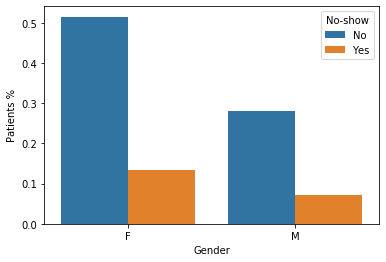

In [7]:
copy= train_data.copy()
d = copy.groupby('Gender')["No-show"].value_counts().to_frame()
d = d.rename({"No-show": 'Patients %'}, axis=1).reset_index()
d['Patients %'] = d['Patients %']/len(copy)
ax = sns.barplot(x='Gender', y= 'Patients %',orient='v', hue='No-show', data=d)

In [8]:
train_data.drop('Gender', axis=1, inplace=True)
train_data.drop('AppointmentID', axis=1, inplace=True)
train_data.drop('Unnamed: 0', axis=1, inplace=True)
test_data.drop('Gender', axis=1, inplace=True)
test_data.drop('AppointmentID', axis=1, inplace=True)
test_data.drop('Unnamed: 0', axis=1, inplace=True)


## Controllo dei valori nulli e delle stringhe vuote

In [9]:
numerical_columns = [col for col in train_data.columns if (train_data[col].dtype == 'int64' or train_data[col].dtype == 'float64')]
numerical_columns
for col in numerical_columns:
     print(col, train_data[col].isnull().sum())

PatientId 0
Age 0
Scholarship 0
Hipertension 0
Diabetes 0
Alcoholism 0
Handcap 0
SMS_received 0


In [10]:
numerical_columns = [col for col in test_data.columns if (test_data[col].dtype == 'int64' or test_data[col].dtype == 'float64')]
numerical_columns
for col in numerical_columns:
     print(col, test_data[col].isnull().sum())

PatientId 0
Age 0
Scholarship 0
Hipertension 0
Diabetes 0
Alcoholism 0
Handcap 0
SMS_received 0


In [11]:
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
categorical_columns
for col in categorical_columns:
    cont = 0
    for value in train_data[col]:
        if not value.strip():   
            cont += 1
    print(col, cont)

No-show 0
ScheduledDay 0
AppointmentDay 0
Neighbourhood 0


In [12]:
categorical_columns = [col for col in test_data.columns if test_data[col].dtype == 'object']
categorical_columns
for col in categorical_columns:
    cont = 0
    for value in test_data[col]:
        if not value.strip():   
            cont += 1
    print(col, cont)

No-show 0
ScheduledDay 0
AppointmentDay 0
Neighbourhood 0


## -Casting delle stringhe  AppointmentDay e ScheduledDay a tipo Ordinal

## -Aggiunta di una nuova colonna 'differenceBtDates' che indica i giorni che intercorrono dalla data di prenotazione e la data della visita effettiva.
## -Eliminizione delle righe che hanno un valore negativo nel campo 'differenceBtDates'.

In [13]:
train_data["AppointmentDay"]=pd.to_datetime(train_data["AppointmentDay"]).dt.date
train_data["ScheduledDay"]=pd.to_datetime(train_data["ScheduledDay"]).dt.date
test_data["AppointmentDay"]=pd.to_datetime(test_data["AppointmentDay"]).dt.date
test_data["ScheduledDay"]=pd.to_datetime(test_data["ScheduledDay"]).dt.date


train_data["AppointmentDay"] = train_data["AppointmentDay"].apply(lambda x : x.toordinal())
train_data["ScheduledDay"] = train_data["ScheduledDay"].apply(lambda x : x.toordinal())
test_data["AppointmentDay"] = test_data["AppointmentDay"].apply(lambda x : x.toordinal())
test_data["ScheduledDay"] = test_data["ScheduledDay"].apply(lambda x : x.toordinal())

differenceBtDatesTrain=(train_data["AppointmentDay"] - train_data["ScheduledDay"])
differenceBtDatesTest=(test_data["AppointmentDay"] - test_data["ScheduledDay"])
train_data["differenceBtDates"] = differenceBtDatesTrain
test_data["differenceBtDates"] = differenceBtDatesTest
train_data[train_data["differenceBtDates"]  < 0]

,No-show,PatientId,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,differenceBtDates
5620,Yes,7.839273e+12,736094,736093,38,RESISTÊNCIA,0,0,0,0,1,0,-1
52502,Yes,2.425226e+13,736089,736088,22,CONSOLAÇÃO,0,0,0,0,0,0,-1


In [14]:
test_data[test_data["differenceBtDates"]  < 0]


,No-show,PatientId,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,differenceBtDates
18422,Yes,9.982316e+14,736095,736089,81,SANTO ANTÔNIO,0,0,0,0,0,0,-6


In [15]:
train_data.drop(train_data[train_data["differenceBtDates"]  < 0].index, inplace=True)
test_data.drop(test_data[test_data["differenceBtDates"]  < 0].index, inplace=True)

In [16]:
categoricalFeatures = train_data.select_dtypes(include=["object","float64","timedelta64","datetime64"]).columns
categoricalFeatures

Index(['No-show', 'PatientId', 'Neighbourhood'], dtype='object')

In [17]:
categoricalFeatures = test_data.select_dtypes(include=["object","float64","timedelta64","datetime64"]).columns
categoricalFeatures

Index(['No-show', 'PatientId', 'Neighbourhood'], dtype='object')

### Procedura di labeling per variabili categoriche

In [18]:
label_train_data=train_data.copy()
label_test_data=test_data.copy()
label_encoder=LabelEncoder()
for col in categoricalFeatures:
    label_train_data[col]=label_encoder.fit_transform(label_train_data[col])
for col in categoricalFeatures:
    label_test_data[col]=label_encoder.fit_transform(label_test_data[col])

In [19]:
target="No-show"

train_y=label_train_data[target]
train_x=label_train_data.drop(target, axis=1)

test_y=label_test_data[target]
test_x=label_test_data.drop(target, axis=1)



In [20]:
label_train_data

,No-show,PatientId,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,differenceBtDates
0,1,8655,736069,736102,29,66,0,0,0,0,0,0,33
1,0,5944,736121,736121,5,41,0,0,0,0,0,0,0
2,0,37617,736074,736094,64,39,0,0,0,0,0,1,20
3,0,40559,736103,736103,66,55,0,1,0,0,0,0,0
4,0,8209,736114,736114,72,59,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66310,0,15786,736103,736117,11,70,0,0,0,0,0,1,14
66311,0,30175,736074,736095,50,78,0,1,1,0,0,1,21
66312,0,40128,736116,736116,42,1,0,0,0,0,0,0,0
66313,1,10730,736067,736089,13,5,0,0,0,0,0,1,22


### Modellazione e allenamento

In [21]:
model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=False, 
                   intercept_scaling=1, class_weight='Balanced', random_state=None, solver='lbfgs', 
                   max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=10, l1_ratio=None)
model.fit(train_x,train_y)
val_pred=model.predict(test_x)



Using Logistic Regression we have an accuracy of: 80.19904998869035 %


## Accuracy

In [26]:
print("Accuracy ottenuta:", accuracy_score(test_y,val_pred.round())*100, "%")

Accuracy ottenuta: 80.19904998869035 %
